In [5]:
import datetime

import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from access import Access, weights, Datasets
from typing import List
import os
from pathlib import Path
import pickle
import re
import shapely
import igraph as ig
from tqdm import tqdm
from scipy import stats
from inequality.theil import TheilD

import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

from matplotlib import pyplot as plt
from copy import copy
pd.options.mode.chained_assignment = None

# TODO:
- [x] Load OD pairs for each graph
- [x] Load *cleaned* group data for the respective year
- [x] Load Amsterdam Buurten map
- [x] Join group data with Buurten map
- [ ] Compute threshold COM per group per graph
- [ ] Define social equity measure
- [ ] Compute Theil inequality index

# Data Preparation

In [6]:
OD_MAT_DIR = Path("/home/rico/Documents/thesis/eda/notebooks/sampled_graphs")
AMS_DATA_BASE_DIR = Path("/home/rico/Documents/thesis/eda/data/Amsterdam/")
GRAPH_DATA_DIR = Path("/home/rico/Documents/thesis/eda/notebooks/sample_data/transit_graphs")

In [7]:
od_mats = [OD_MAT_DIR.joinpath(file) for file in os.listdir(OD_MAT_DIR) if Path(file).suffix == '.pkl']
od_mats_2019 = [od_mat_path for od_mat_path in od_mats if '2019' in od_mat_path.name]
od_mats_2020 = [od_mat_path for od_mat_path in od_mats if '2020' in od_mat_path.name]
od_mats_2021 = [od_mat_path for od_mat_path in od_mats if '2021' in od_mat_path.name]
od_mats_pa = {2019: od_mats_2019, 2020: od_mats_2020, 2021: od_mats_2021}

print(f"Obtained number of OD Matrices: 2019 - {len(od_mats_2019)}, 2020 - {len(od_mats_2020)}, 2021 - {len(od_mats_2021)}")

Obtained number of OD Matrices: 2019 - 52, 2020 - 52, 2021 - 52


In [8]:
graph_folders = [d for d in os.listdir(GRAPH_DATA_DIR) if os.path.isdir(GRAPH_DATA_DIR.joinpath(d))]
graphs = [GRAPH_DATA_DIR.joinpath(folder).joinpath(file) for folder in graph_folders for file in
          os.listdir(GRAPH_DATA_DIR.joinpath(folder)) if Path(file).suffix == '.gml']

In [9]:
destinations = gpd.read_file("/home/rico/Documents/thesis/eda/data/Amsterdam/non_residential_functions_geojson_latlng.json")
cat_to_exclude = ['Wonen', 'Coffeeshop', 'Prostitutie', 'Logies']
destinations = destinations[~destinations.Functie.isin(cat_to_exclude)]
education = destinations[destinations.Functie == 'Onderwijs']
education.geometry = gpd.points_from_xy(education.geometry.y, education.geometry.x, crs='EPSG:4326')

In [10]:
# Read Amstedam Neighborhoods
# Plot them using ams_nb.plot()
ams_nb = gpd.read_file('/home/rico/Documents/thesis/eda/notebooks/sample_data/amsterdam/ams-neighbourhoods.geojson')
ams_nb['centroid'] = gpd.points_from_xy(ams_nb.cent_x, ams_nb.cent_y, crs='EPSG:4326')
ams_nb['res_centroid'] = gpd.points_from_xy(ams_nb.res_cent_x, ams_nb.res_cent_y, crs='EPSG:4326')
education['geometry'] = gpd.points_from_xy(education.geometry.x, education.geometry.y, crs='EPSG:4326')
# Places without residential buildings have no residential centroids. Find them and assign to them the geographical centroid.
ams_nb.loc[ams_nb['res_cent_x'].isna(), 'res_centroid'] = ams_nb[ams_nb['res_cent_x'].isna()]['centroid']

In [11]:
CLEANED_AMS_NHS_DIR = AMS_DATA_BASE_DIR.joinpath('cleaned_neighbourhood_data/')

def load_geometry_fields(gdf: gpd.GeoDataFrame, fields: List[str]):
    for field in fields:
        gdf[field] = gdf[field].apply(shapely.wkt.loads)
    return gdf

kwb_19_ams_neighborhoods = gpd.read_parquet(CLEANED_AMS_NHS_DIR.joinpath('kwb_19_ams_neighborhoods.parquet'))
kwb_20_ams_neighborhoods = gpd.read_parquet(CLEANED_AMS_NHS_DIR.joinpath('kwb_20_ams_neighborhoods.parquet'))
kwb_21_ams_neighborhoods = gpd.read_parquet(CLEANED_AMS_NHS_DIR.joinpath('kwb_21_ams_neighborhoods.parquet'))

# kwb_19_ams_neighborhoods = load_geometry_fields(kwb_19_ams_neighborhoods, ['geometry', 'centroid', 'res_centroid'])
# kwb_20_ams_neighborhoods = load_geometry_fields(kwb_20_ams_neighborhoods, ['geometry', 'centroid', 'res_centroid'])
# kwb_21_ams_neighborhoods = load_geometry_fields(kwb_21_ams_neighborhoods, ['geometry', 'centroid', 'res_centroid'])

assert kwb_19_ams_neighborhoods.columns.tolist() == kwb_20_ams_neighborhoods.columns.tolist() == kwb_21_ams_neighborhoods.columns.tolist()

In [12]:
# tmp_df = pd.concat([kwb_21_ams_neighborhoods.BU_CODE,kwb_21_ams_neighborhoods.a_inw, kwb_21_ams_neighborhoods.res_centroid.x, kwb_21_ams_neighborhoods.res_centroid.y], axis=1) # .to_file('/home/rico/Documents/thesis/eda/notebooks/sample_data/amsterdam/ams-neighbourhoods-fixed-centroids.csv')
# tmp_df['res_centroid_x'] = tmp_df[0]
# tmp_df['res_centroid_y'] = tmp_df[1]
# tmp_df = tmp_df.drop(columns=[0,1])
# tmp_df.to_csv('//home/rico/Documents/thesis/eda/notebooks/sample_setup/ams-nhs-fixed-centroids.csv', index=False)

# Social Equity Definition
## What groups are we looking at?
This depends on the type of opportunity we are looking at. Our current investigation is for education. Hence, we will be looking at `a_w_all` and `a_nw_all`, i.e. western vs. non-western pop. respectively, as well as `a_00_14` and `a_15_24` which are age groups from 0-14 and 15-25 years respectively. From the percentage of western/non-western population in a specific region, we then get a distribution that we assume to be similar on the age groups. That way we can not only identify western vs. non-western but also western vs. non-western in the relevant age-span.

We furthermore look at the income per capita:

# Equity Computation

In [13]:
group_dicts = {
    "full_df": None,
    "percent_western": None,
    "percent_non_western": None,
    "percent_to_school": None,
    "percent_hh_with_kids": None,
    "percent_lowest_40p_income_hh": None
}

data_dict = {2019: copy(group_dicts), 2020: copy(group_dicts), 2021: copy(group_dicts)}

data_dict[2019]["full_df"] = kwb_19_ams_neighborhoods.dropna()
data_dict[2020]["full_df"] = kwb_20_ams_neighborhoods.dropna()
data_dict[2021]["full_df"] = kwb_21_ams_neighborhoods.dropna()

# Percent westerners
# Percent non-westerners
# Percent inhabitants to be schooled
# Percent households with kids
# Percent of households in the Netherlands' 40% of households with the lowest income

In [14]:
for year in data_dict:
    curr_entry = data_dict[year]

    fields_to_retain = ['BU_CODE', 'geometry', 'a_inw', 'a_hh']

    curr_entry["percent_western"] = curr_entry["full_df"][fields_to_retain + ['a_w_all', 'a_nw_all']]
    sum_w_nw = curr_entry["percent_western"]['a_w_all'] + curr_entry["percent_western"]['a_nw_all']

    curr_entry["percent_western"]['p_w'] = curr_entry["percent_western"]['a_w_all'] / sum_w_nw

    curr_entry["percent_western"] = curr_entry["percent_western"].drop(columns=['a_w_all', 'a_nw_all'])
    curr_entry["percent_western"] = curr_entry["percent_western"].dropna()

    curr_entry["percent_western"]['n_w'] = curr_entry["percent_western"]['a_inw'] * curr_entry["percent_western"]['p_w']
    curr_entry["percent_western"]['n_w'] = curr_entry["percent_western"]['n_w'].astype('int')
    curr_entry["percent_western"]['n_nw'] = curr_entry["percent_western"]['a_inw'] - curr_entry["percent_western"]['n_w']

    curr_entry["percent_western"]['p_of_total_w'] = curr_entry["percent_western"]['n_w'] / curr_entry["percent_western"]['n_w'].sum()
    curr_entry["percent_western"]['p_of_total_nw'] = curr_entry["percent_western"]['n_nw'] / curr_entry["percent_western"]['n_nw'].sum()

    curr_entry["percent_non_western"] = curr_entry["full_df"][fields_to_retain]
    curr_entry["percent_non_western"]['p_nw'] = 1 - curr_entry["percent_western"]['p_w']
    curr_entry["percent_non_western"] = curr_entry["percent_non_western"].dropna()

    curr_entry["percent_to_school"] = curr_entry["full_df"][fields_to_retain + ['a_00_14', 'a_15_24']]
    curr_entry["percent_to_school"]['a_00_24'] = curr_entry["percent_to_school"]['a_00_14'] + curr_entry["percent_to_school"]['a_15_24']
    curr_entry["percent_to_school"]['p_00_24'] = curr_entry["percent_to_school"]['a_00_24'] / curr_entry["percent_to_school"]['a_inw']
    curr_entry["percent_to_school"] = curr_entry["percent_to_school"].drop(columns=['a_00_14', 'a_15_24', 'a_00_24'])
    curr_entry["percent_to_school"] = curr_entry["percent_to_school"].dropna()

    curr_entry["percent_hh_with_kids"] = curr_entry["full_df"][fields_to_retain + ['a_hh_m_k']]
    curr_entry["percent_hh_with_kids"]['p_hh_m_k'] = curr_entry["percent_hh_with_kids"]['a_hh_m_k'] / curr_entry["percent_hh_with_kids"]['a_hh']
    curr_entry["percent_hh_with_kids"] = curr_entry["percent_hh_with_kids"].drop(columns=['a_hh_m_k'])
    curr_entry["percent_hh_with_kids"] = curr_entry["percent_hh_with_kids"].dropna()

    curr_entry["percent_lowest_40p_income_hh"] = curr_entry["full_df"][fields_to_retain + ['p_hh_li']]
    curr_entry["percent_lowest_40p_income_hh"] = curr_entry["percent_lowest_40p_income_hh"].dropna()

    final_buurten = set(curr_entry["percent_western"]["BU_CODE"].tolist()) &\
                    set(curr_entry["percent_non_western"]["BU_CODE"].tolist()) &\
                    set(curr_entry["percent_to_school"]["BU_CODE"].tolist()) &\
                    set(curr_entry["percent_hh_with_kids"]["BU_CODE"].tolist()) &\
                    set(curr_entry["percent_lowest_40p_income_hh"]["BU_CODE"].tolist())

    curr_entry["full_df"] = curr_entry["full_df"][curr_entry["full_df"]["BU_CODE"].isin(final_buurten)]
    curr_entry["percent_western"] = curr_entry["percent_western"][curr_entry["percent_western"]["BU_CODE"].isin(final_buurten)]
    curr_entry["percent_non_western"] = curr_entry["percent_non_western"][curr_entry["percent_non_western"]["BU_CODE"].isin(final_buurten)]
    curr_entry["percent_to_school"] = curr_entry["percent_to_school"][curr_entry["percent_to_school"]["BU_CODE"].isin(final_buurten)]
    curr_entry["percent_hh_with_kids"] = curr_entry["percent_hh_with_kids"][curr_entry["percent_hh_with_kids"]["BU_CODE"].isin(final_buurten)]
    curr_entry["percent_lowest_40p_income_hh"] = curr_entry["percent_lowest_40p_income_hh"][curr_entry["percent_lowest_40p_income_hh"]["BU_CODE"].isin(final_buurten)]

In [15]:
# Final check that all buurten have the same information
buurten = set(data_dict[2019]["full_df"]["BU_CODE"].tolist()) &\
          set(data_dict[2020]["full_df"]["BU_CODE"].tolist()) &\
          set(data_dict[2021]["full_df"]["BU_CODE"].tolist())

for year in data_dict:
    curr = data_dict[year]
    for entry in curr:
        curr[entry] = curr[entry][curr[entry]["BU_CODE"].isin(buurten)]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

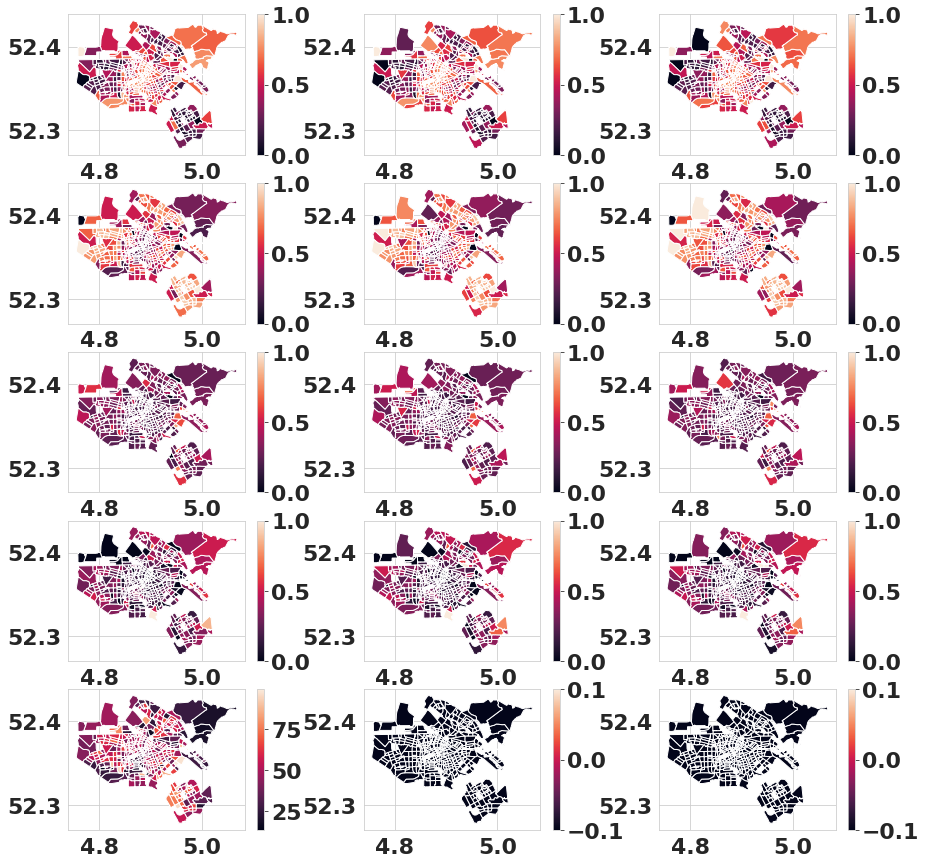

In [16]:
fig, ax = plt.subplots(5,3, figsize=(15,15))
data_dict[2019]["percent_western"].plot(column='p_w', ax=ax[0][0], legend=True)
data_dict[2020]["percent_western"].plot(column='p_w', ax=ax[0][1], legend=True)
data_dict[2021]["percent_western"].plot(column='p_w', ax=ax[0][2], legend=True)

data_dict[2019]["percent_non_western"].plot(column='p_nw', ax=ax[1][0], legend=True)
data_dict[2020]["percent_non_western"].plot(column='p_nw', ax=ax[1][1], legend=True)
data_dict[2021]["percent_non_western"].plot(column='p_nw', ax=ax[1][2], legend=True)

data_dict[2019]["percent_to_school"].plot(column='p_00_24', ax=ax[2][0], legend=True)
data_dict[2020]["percent_to_school"].plot(column='p_00_24', ax=ax[2][1], legend=True)
data_dict[2021]["percent_to_school"].plot(column='p_00_24', ax=ax[2][2], legend=True)

data_dict[2019]["percent_hh_with_kids"].plot(column='p_hh_m_k', ax=ax[3][0], legend=True)
data_dict[2020]["percent_hh_with_kids"].plot(column='p_hh_m_k', ax=ax[3][1], legend=True)
data_dict[2021]["percent_hh_with_kids"].plot(column='p_hh_m_k', ax=ax[3][2], legend=True)

data_dict[2019]["percent_lowest_40p_income_hh"].plot(column='p_hh_li', ax=ax[4][0], legend=True)
data_dict[2020]["percent_lowest_40p_income_hh"].plot(column='p_hh_li', ax=ax[4][1], legend=True)
data_dict[2021]["percent_lowest_40p_income_hh"].plot(column='p_hh_li', ax=ax[4][2], legend=True)

In [17]:
def compute_statistics(date, tt_df, modes_df, lines_df, hops_df):
    agg_df_cols = ['date', 'metric'] + tt_df.index.to_list()
    aggregate_statistics = pd.DataFrame(columns=agg_df_cols)

    buurt_avg_tt = tt_df.replace(0, np.NaN).mean(axis=1)
    buurt_avg_modes = modes_df.replace(0, np.NaN).mean(axis=1)
    buurt_avg_lines = lines_df.replace(0, np.NaN).mean(axis=1)
    buurt_avg_hops = hops_df.replace(0, np.NaN).mean(axis=1)

    # Threshold stats
    thr_df = tt_df.copy(deep=True)
    thr_df[thr_df > 15] = 0
    thr_df[thr_df > 0] = 1
    buurt_15min_pois = thr_df.replace(0, np.NaN).sum(axis=1)

    buurt_avg_tt_df = pd.DataFrame([[date, 'avg_tt'] + list(buurt_avg_tt.values)], columns=agg_df_cols, index=[0])
    buurt_avg_modes_df = pd.DataFrame([[date, 'avg_modes'] + list(buurt_avg_modes.values)], columns=agg_df_cols, index=[0])
    buurt_avg_lines_df = pd.DataFrame([[date, 'avg_lines'] + list(buurt_avg_lines.values)], columns=agg_df_cols, index=[0])
    buurt_avg_hops_df = pd.DataFrame([[date, 'avg_hops'] + list(buurt_avg_hops.values)], columns=agg_df_cols, index=[0])
    buurt_15min_pois_df = pd.DataFrame([[date, 'thr_15min_pois'] + list(buurt_15min_pois.values)], columns=agg_df_cols, index=[0])

    aggregate_statistics = pd.concat([aggregate_statistics, buurt_avg_tt_df,
                                      buurt_avg_modes_df, buurt_avg_lines_df,
                                      buurt_avg_hops_df, buurt_15min_pois_df])

    aggregate_statistics = aggregate_statistics.dropna(axis=1)

    return aggregate_statistics


def compute_trend_df(date, metric_df, metric):
    y = metric_df[0].dropna().to_numpy().astype(np.float64)
    X = metric_df[~metric_df[0].isna()].p_w.to_numpy()
    slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)

    return pd.DataFrame([[date, metric, slope, intercept, r_value, p_value, std_err]],
                        columns=['date', 'metric', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])


In [41]:
complete_stats = pd.DataFrame()
nw_to_w_trend = pd.DataFrame()
inequalities = pd.DataFrame()

for year in tqdm(od_mats_pa, position=0):
    curr_year_od_mats = od_mats_pa[year]

    for curr_od_mat_path in curr_year_od_mats:
        with open(curr_od_mat_path, 'rb') as fp:
            tt_mx, modes_mx, lines_mx, hops_mx, _ = pickle.load(fp)

        od_mat_date = re.findall('\d+',curr_od_mat_path.name)[0]
        month = int(od_mat_date[4:6])
        day = int(od_mat_date[6:])
        date = datetime.datetime(year, month, day)

        base_tt_df = pd.DataFrame(data=tt_mx, index=ams_nb.BU_CODE)
        base_modes_df = pd.DataFrame(data=modes_mx, index=ams_nb.BU_CODE)
        base_lines_df = pd.DataFrame(data=lines_mx, index=ams_nb.BU_CODE)
        base_hops_df = pd.DataFrame(data=hops_mx, index=ams_nb.BU_CODE)

        stats_df = compute_statistics(date, base_tt_df, base_modes_df, base_lines_df, base_hops_df)
        complete_stats = pd.concat([complete_stats, stats_df], ignore_index=True, verify_integrity=True)

        # Compute trend of between-group inequality
        def get_trend_df(metric: str) -> pd.DataFrame:
            mergeable_avg_metric = stats_df[stats_df.metric==metric].drop(columns=['date','metric']).iloc[0,:].reset_index()
            buurt_avg_metric = gpd.pd.merge(mergeable_avg_metric, data_dict[year]["percent_western"], left_on='index', right_on="BU_CODE")

            return compute_trend_df(date, buurt_avg_metric, metric)

        nw_to_w_trend = pd.concat([nw_to_w_trend, get_trend_df('avg_tt'), get_trend_df('thr_15min_pois')],
                                  ignore_index=True, verify_integrity=True)

        # Compute TheilD inequality
        def get_TheilD_df(metric: str) -> pd.DataFrame:
            t = stats_df[stats_df.metric==metric].drop(columns=['date','metric']).T

            w_nw_df = data_dict[year]['percent_western'].copy(deep=True)
            w_nw_df.index = w_nw_df.BU_CODE

            common_indices = list(set(t.index).intersection(set(w_nw_df.index)))
            valid_t = t.loc[common_indices].join(w_nw_df[['n_w','n_nw']])

            w_individuals = np.repeat(valid_t[0].values, valid_t['n_w'])
            w_individuals = w_individuals.reshape((-1,1))
            w_individuals = np.hstack([w_individuals, np.ones((len(w_individuals),1))])

            nw_individuals = np.repeat(valid_t[0].values, valid_t['n_nw'])
            nw_individuals = nw_individuals.reshape((-1,1))
            nw_individuals = np.hstack([nw_individuals, np.ones((len(nw_individuals),1)) + 1])

            total_individuals = np.append(w_individuals, nw_individuals, axis=0)
            total_individuals = total_individuals.astype(np.float64)

            theild_comp = TheilD(total_individuals[:,0].T,total_individuals[:,1].T)

            return pd.DataFrame([[date, metric, theild_comp.T, theild_comp.bg[0], theild_comp.wg[0]]],
                                columns=['date', 'metric', 'theil_inequality', 'theil_bg_inequality', 'theil_wg_inequality'])

        inequalities = pd.concat([inequalities, get_TheilD_df('avg_tt'), get_TheilD_df('thr_15min_pois')],
                                 ignore_index=True, verify_integrity=True)
        break
    break

  0%|          | 0/3 [00:06<?, ?it/s]


In [42]:
total_individuals

NameError: name 'total_individuals' is not defined

In [ ]:
# Save
# complete_stats.to_csv("/home/rico/Documents/thesis/eda/notebooks/results/complete_stats.csv")
# nw_to_w_trend.to_csv("/home/rico/Documents/thesis/eda/notebooks/results/nw_to_w_trend.csv")
# inequalities.to_csv("/home/rico/Documents/thesis/eda/notebooks/results/inequalities.csv")

In [ ]:
# Couple the graph interventions with the computed inequalities


# Experimentation

In [19]:
base_od_mats_2019_path = od_mats_2019[0]
with open(base_od_mats_2019_path, 'rb') as fp:
    tt_mx, modes_mx, lines_mx, hops_mx, failed = pickle.load(fp)

In [20]:
base_2019_tt_mat = tt_mx
df = pd.DataFrame(data=base_2019_tt_mat, index=ams_nb.BU_CODE)
buurt_avg_tt = df.replace(0,np.NaN).mean(axis=1)
buurt_avg_tt = gpd.pd.merge(buurt_avg_tt.to_frame(), data_dict[2019]["percent_western"], on="BU_CODE")
buurt_avg_tt = gpd.GeoDataFrame(buurt_avg_tt)

<AxesSubplot:>

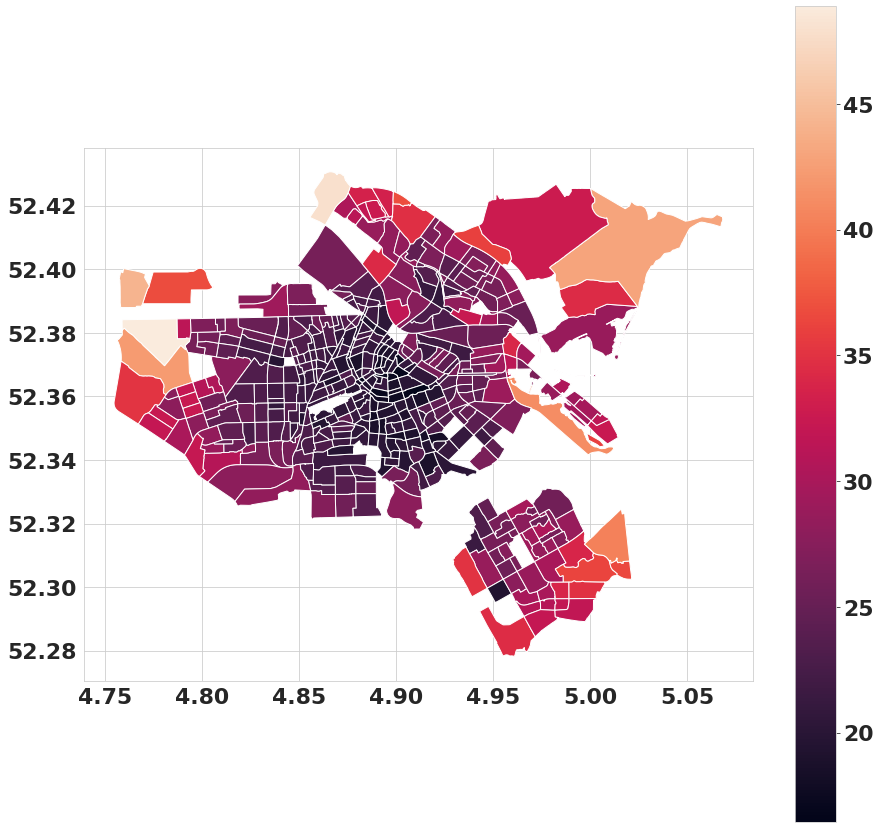

In [21]:
buurt_avg_tt.plot(0, legend=True,figsize=(15,15))

In [23]:
buurt_avg_tt

,BU_CODE,0,geometry,a_inw,a_hh,p_w,n_w,n_nw,p_of_total_w,p_of_total_nw
0,BU03630000,20.410498,"POLYGON ((4.90096 52.37724, 4.90195 52.37724, ...",1035,755,0.660194,683,352,0.002031,0.000673
1,BU03630001,19.071897,"POLYGON ((4.89651 52.37575, 4.89707 52.37550, ...",705,505,0.694444,489,216,0.001454,0.000413
2,BU03630002,18.919578,"POLYGON ((4.89966 52.37468, 4.90002 52.37455, ...",1570,1105,0.635802,998,572,0.002967,0.001094
3,BU03630003,18.643491,"POLYGON ((4.89301 52.37271, 4.89331 52.37264, ...",350,235,0.781250,273,77,0.000812,0.000147
4,BU03630004,19.401408,"POLYGON ((4.89613 52.37177, 4.89670 52.37157, ...",625,435,0.636364,397,228,0.001180,0.000436
...,...,...,...,...,...,...,...,...,...,...
437,BU03639701,31.969534,"POLYGON ((4.98456 52.29633, 4.98508 52.29633, ...",1685,870,0.115108,193,1492,0.000574,0.002853
438,BU03639702,34.870108,"POLYGON ((4.99197 52.30193, 4.99202 52.30192, ...",3310,1405,0.287975,953,2357,0.002833,0.004507
439,BU03639703,31.808990,"POLYGON ((5.00325 52.29639, 5.00325 52.29637, ...",3420,1645,0.182243,623,2797,0.001852,0.005348
440,BU03639800,36.475384,"POLYGON ((5.01377 52.30914, 5.01408 52.30907, ...",1485,635,0.476190,707,778,0.002102,0.001488


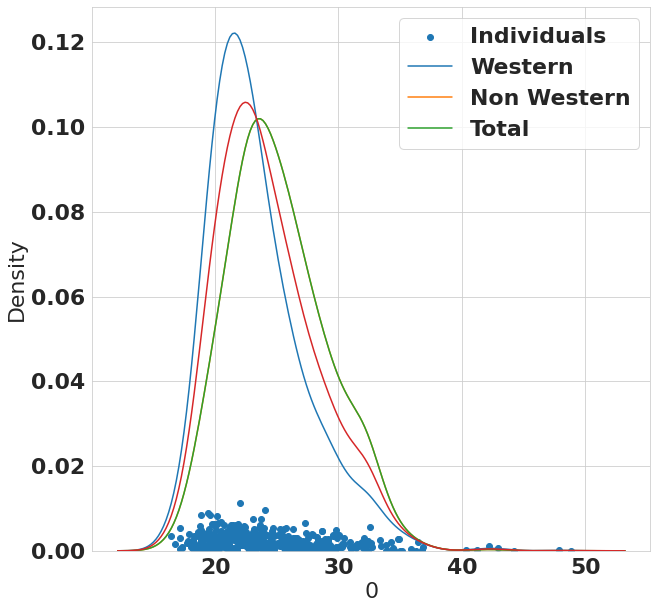

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.scatter(buurt_avg_tt[0], buurt_avg_tt['p_of_total_w'])
sns.kdeplot(buurt_avg_tt[0], ax=ax, weights=buurt_avg_tt['p_of_total_w'])
sns.kdeplot(buurt_avg_tt[0], ax=ax, weights=buurt_avg_tt['p_of_total_nw'])
sns.kdeplot(buurt_avg_tt[0], ax=ax, weights=buurt_avg_tt['p_of_total_nw'])
sns.kdeplot(buurt_avg_tt[0], ax=ax, weights=buurt_avg_tt['p_of_total_nw']+buurt_avg_tt['p_of_total_w'])
ax.legend(labels=['Individuals', 'Western','Non Western','Total'])

In [20]:
base_2019_modes_mat = modes_mx
df = pd.DataFrame(data=base_2019_modes_mat, index=ams_nb.BU_CODE)
buurt_avg_modes = df.replace(0,np.NaN).mean(axis=1)
buurt_avg_modes = gpd.pd.merge(buurt_avg_modes.to_frame(), data_dict[2019]["percent_western"], on="BU_CODE")
buurt_avg_modes = gpd.GeoDataFrame(buurt_avg_modes)

<AxesSubplot:>

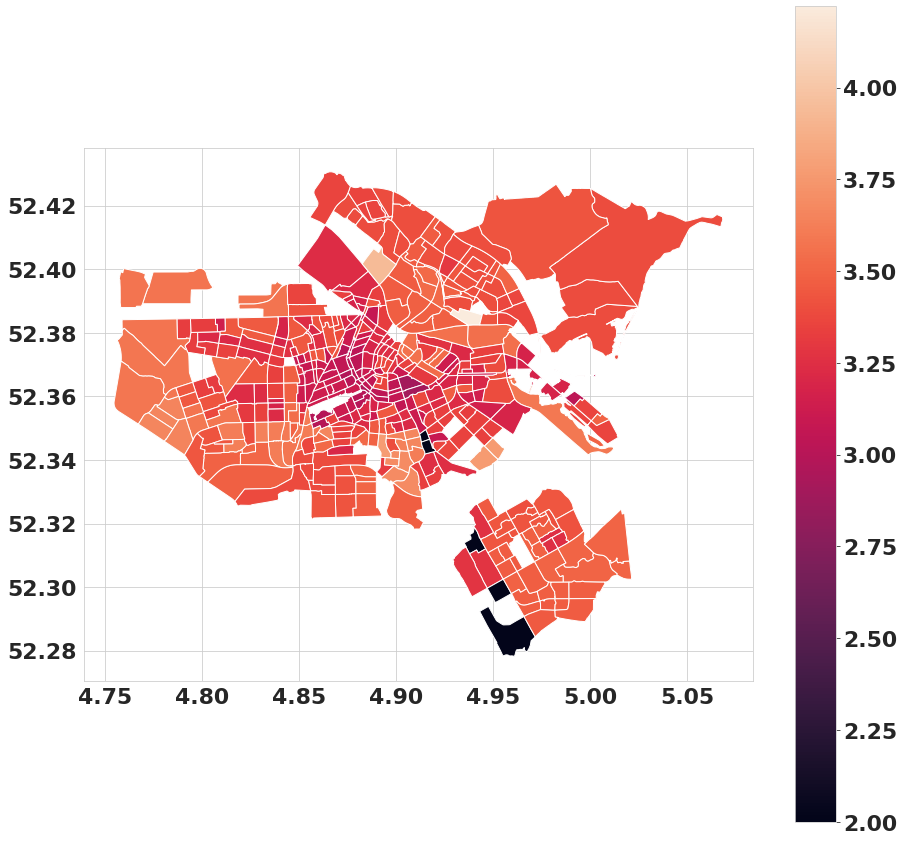

In [21]:
buurt_avg_modes.plot(0, legend=True,figsize=(15,15))

In [22]:
base_2019_lines_mat = lines_mx
df = pd.DataFrame(data=base_2019_lines_mat, index=ams_nb.BU_CODE)
buurt_avg_lines = df.replace(0, np.NaN).mean(axis=1)
buurt_avg_lines = gpd.pd.merge(buurt_avg_lines.to_frame(), data_dict[2019]["percent_western"], on="BU_CODE")
buurt_avg_lines = gpd.GeoDataFrame(buurt_avg_lines)

<AxesSubplot:>

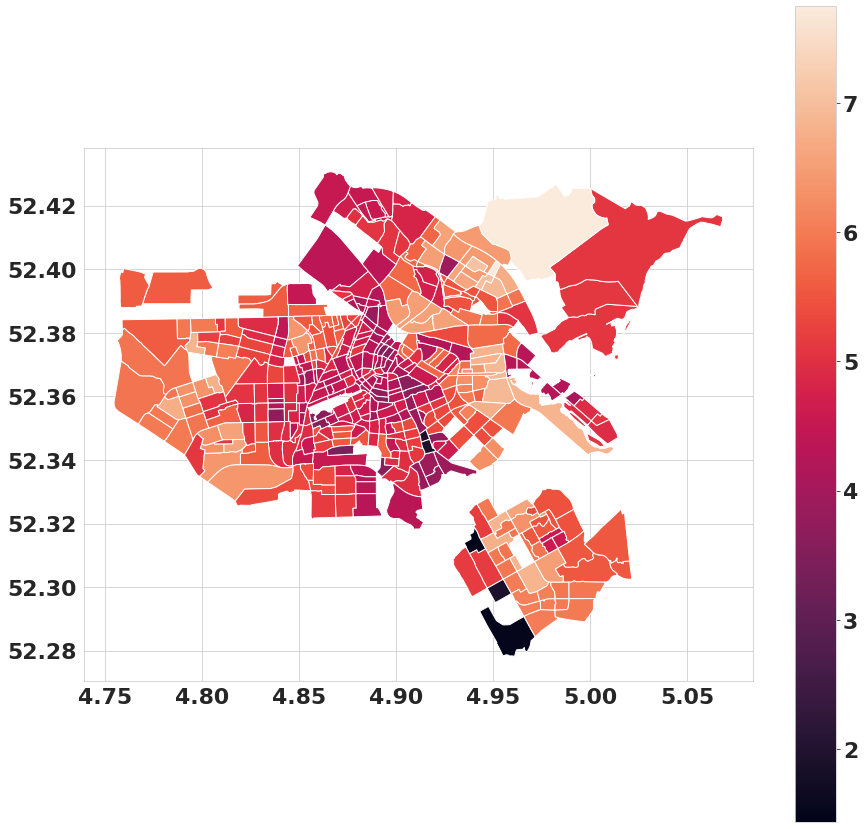

In [23]:
buurt_avg_lines.plot(0, legend=True, figsize=(15, 15))

In [24]:
base_2019_hops_mat = hops_mx
df = pd.DataFrame(data=base_2019_hops_mat, index=ams_nb.BU_CODE)
buurt_avg_hops = df.replace(0, np.NaN).mean(axis=1)
buurt_avg_hops = gpd.pd.merge(buurt_avg_hops.to_frame(), data_dict[2019]["percent_western"], on="BU_CODE")
buurt_avg_hops = gpd.GeoDataFrame(buurt_avg_hops)

<AxesSubplot:>

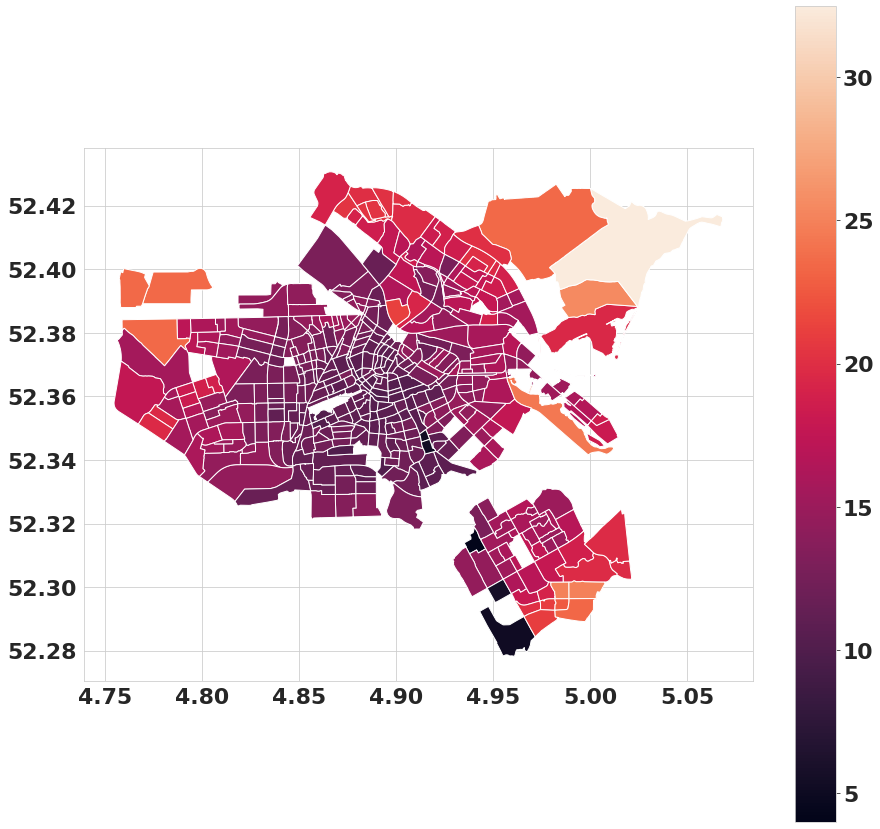

In [25]:
buurt_avg_hops.plot(0, legend=True, figsize=(15, 15))

In [26]:
df = pd.DataFrame(data=base_2019_tt_mat, index=ams_nb.BU_CODE)
df[df > 15] = 0
df[df > 0] = 1
buurt_15min_pois = df.replace(0, np.NaN).sum(axis=1)
buurt_15min_pois = gpd.pd.merge(buurt_15min_pois.to_frame(), data_dict[2019]["percent_western"], on="BU_CODE")
buurt_15min_pois = gpd.GeoDataFrame(buurt_15min_pois)

<AxesSubplot:>

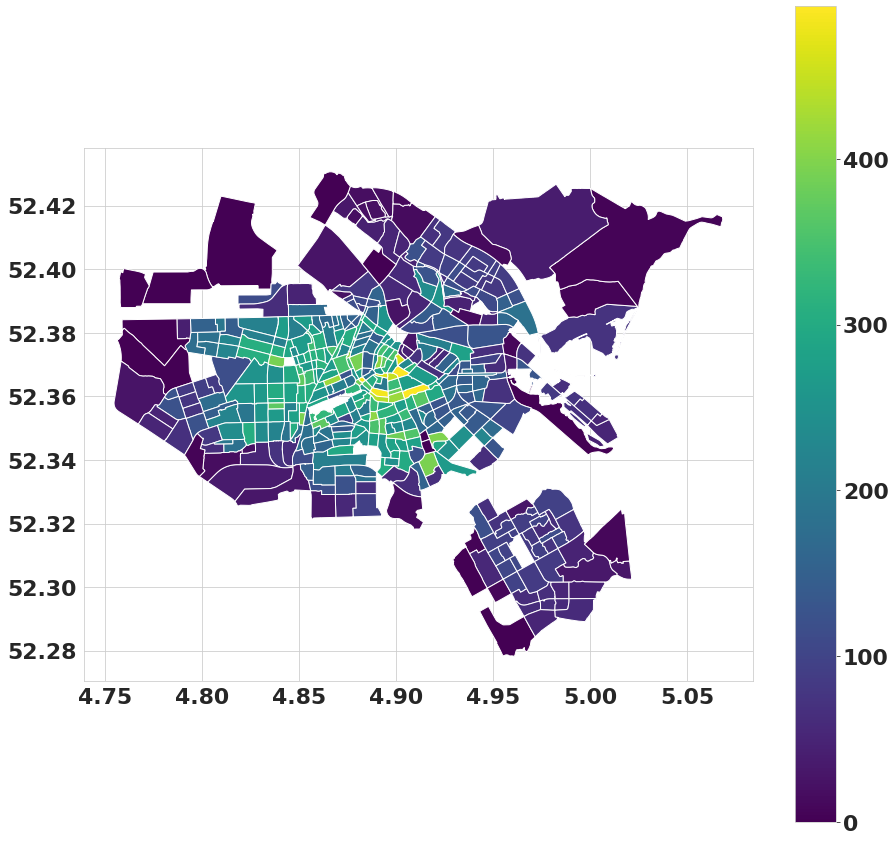

In [27]:
buurt_15min_pois.plot(0, legend=True, figsize=(15, 15), cmap='viridis')

p_value=8.719842685629599e-09 and r_value=-0.2696691723337524 and slope=-6.04136520002911


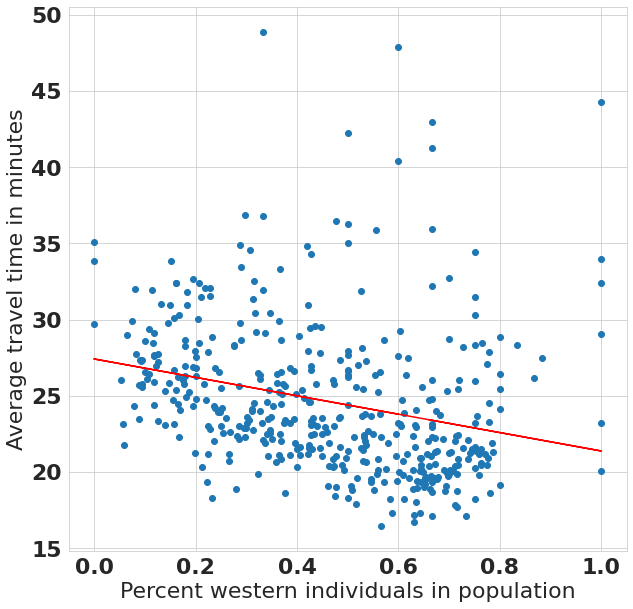

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xlabel('Percent western individuals in population')
ax.set_ylabel('Average travel time in minutes')
y = buurt_avg_tt[0].dropna().to_numpy()
X = buurt_avg_tt[~buurt_avg_tt[0].isna()].p_w.to_numpy()
z = np.polyfit(X, y, 1)
p = np.poly1d(z)

slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)
print(f"{p_value=} and {r_value=} and {slope=}")

ax.scatter(buurt_avg_tt.p_w, buurt_avg_tt[0])
ax.plot(buurt_avg_tt.p_w, p(buurt_avg_tt.p_w), c='r')

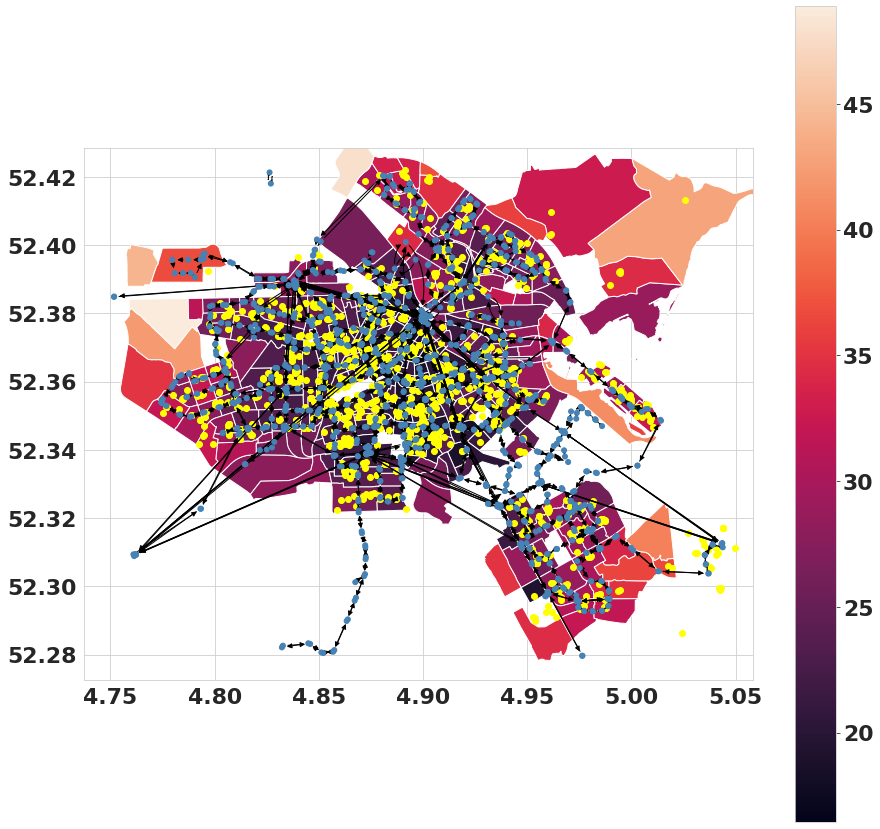

In [29]:
base = buurt_avg_tt.plot(0, legend=True,figsize=(15,15))
base = education.plot(ax=base, color='yellow', figsize=(15,15))
G_transit = ig.read(graphs[0])
ig.plot(G_transit, target=base)